(section:gcn)=
# Graph Convolutional Network

## Description

In this notebook we show an implementation of the Graph Convolutional Network (GCN) for the classification of molecules as mutagenic or non-mutagenic with the MUTAG dataset.

Here we simply define a basic model with several GCN layers of varying shape, and we will find the best hyperparameters.

We will try several variants of :
- Activation functions
- Pooling layers
- Learning rates
- Normalization layers
- Weighting the loss to compensate for class imbalance


## Training
### Dataset loading

In [1]:
from sys import path
import warnings
from os import environ

environ["WANDB_NOTEBOOK_NAME"] = "GCN.ipynb"  # set notebook name for wandb
warnings.filterwarnings(
    "ignore"
)  # ignore warnings from missing deterministic implementation (from wandb, not model itself)
path.append("../code")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import nn
import numpy as np
import seaborn as sns
import model as m
import training as t
import utils
import logging
import sys

from utils import LOG as logger

logging.basicConfig(
    format="%(message)s", level=logging.INFO, stream=sys.stdout
)
logger.setLevel(logging.INFO)
# logger.setLevel(logging.DEBUG)

# t.WANDB_MODE = "disabled"

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
dataloaders, dataset = t.create_dataloaders(
    batch_size=20,
    )

Length of train set: 131
Length of validation set: 28
Length of test set: 29


### Model
Let's initialize the model with our chosen architecture !

In [5]:
node_features = dataset.node_features.shape[2]
conv_dims = [256, 256, 128, 64]
model = m.GCN(
    num_features=node_features,
    conv_dims=conv_dims,
    # fcn_layers=[128],
    activation=nn.SELU(),
    dropout=0.2,
    pooling="max",
    norm=nn.BatchNorm1d,
)

# utils._print_gradient_hook(model)


print(model)

Initialized model with 4 graph conv layers
Initialized model with 1 fully connected layers
GCN(
  (convs_layers): ModuleList(
    (0): GraphConv(
      (weight): Linear(in_features=7, out_features=256, bias=False)
      (bias): Linear(in_features=7, out_features=256, bias=False)
      (activation): SELU()
    )
    (1): GraphConv(
      (weight): Linear(in_features=256, out_features=256, bias=False)
      (bias): Linear(in_features=256, out_features=256, bias=False)
      (activation): SELU()
    )
    (2): GraphConv(
      (weight): Linear(in_features=256, out_features=128, bias=False)
      (bias): Linear(in_features=256, out_features=128, bias=False)
      (activation): SELU()
    )
    (3): GraphConv(
      (weight): Linear(in_features=128, out_features=64, bias=False)
      (bias): Linear(in_features=128, out_features=64, bias=False)
      (activation): Identity()
    )
  )
  (batch_norms): ModuleList(
    (0-1): 2 x BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_run

### Parameters
Now we create the loss function and the optimizer.
We will use the Binary Cross Entropy with the built-in sigmoid for stability,
and use Adam as the optimizer.

In [6]:
learning_rate = 1e-3
epochs = 1000

model.to(DEVICE)

label_counts = dataset.class_y.unique(return_counts=True)[1]
pos_weight = label_counts[0] / label_counts[1]
loss_fn = nn.BCEWithLogitsLoss(
    # pos_weight=torch.tensor(pos_weight) # NOTE : due to an issue with reproducibility, this is not used here, in order to obtain the selected best run. 
                                          # It is however used for the other models.
)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

history = {
    "epoch": 0,
    "loss": [],
    "acc": [],
    "val-roc": [],
    "val-ap": [],
}

### Training loop

Here we train the model.

In [7]:
history = t.train_loop(
    history=history,
    train_dataloader=dataloaders[0],
    val_dataloader=dataloaders[1],
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=epochs,
    device=DEVICE,
    use_scheduler=False,
    test_dataloader=dataloaders[2],
)

wandb: Currently logged in as: c-achard. Use `wandb login --relogin` to force relogin


Epoch   1/1000:Epoch loss: 0.7356 - avg acc: 30.5% - val-roc: 0.7041 - val-ap: 0.6378 (0.3s/epoch)
Epoch   2/1000:Epoch loss: 0.6209 - avg acc: 32.1% - val-roc: 0.8622 - val-ap: 0.9041 (0.1s/epoch)
Epoch   3/1000:Epoch loss: 0.5704 - avg acc: 33.6% - val-roc: 0.8265 - val-ap: 0.8750 (0.1s/epoch)
Epoch   4/1000:Epoch loss: 0.5038 - avg acc: 32.8% - val-roc: 0.7908 - val-ap: 0.8544 (0.1s/epoch)
Epoch   5/1000:Epoch loss: 0.5551 - avg acc: 51.1% - val-roc: 0.7755 - val-ap: 0.8435 (0.1s/epoch)
Epoch   6/1000:Epoch loss: 0.5733 - avg acc: 32.8% - val-roc: 0.7194 - val-ap: 0.7249 (0.1s/epoch)
Epoch   7/1000:Epoch loss: 0.5114 - avg acc: 32.8% - val-roc: 0.7245 - val-ap: 0.6958 (0.1s/epoch)
Epoch   8/1000:Epoch loss: 0.4970 - avg acc: 31.3% - val-roc: 0.7347 - val-ap: 0.7392 (0.1s/epoch)
Epoch   9/1000:Epoch loss: 0.4883 - avg acc: 31.3% - val-roc: 0.6173 - val-ap: 0.5557 (0.1s/epoch)
Epoch  10/1000:Epoch loss: 0.5239 - avg acc: 32.8% - val-roc: 0.6122 - val-ap: 0.5539 (0.1s/epoch)
Epoch  11/

epoch_loss,██▇▇▆▆▅▆▄▅▅▅▅▄▄▄▄▄▄▄▃▃▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▃▂
test/test_ap,▁
test/test_roc,▁
train_acc,▁▁▁▁▁▂▂▂▄▄▄▃▇▅▄▇▅▇▇▇▇▇▇█▇█▇██▇███▇█▇████
train_loss,▆▅▆█▄▆▅▄▄▃▄▆▄▄▃▂▃▄▂▃▃▆▄▄▂▄▆▃▁▃▁▃▄▃▁▂▃▂▁▂
val/val_ap,▅▁▁▁▂▂▁▂▂▃▃▂▅▄▄▃▃▃▄▅▃▃▃▃▆▄▅▄▆▅▄▆█▆▅▅▅▅▆▅
val/val_roc,▅▁▁▂▃▃▁▂▂▄▃▂▄▃▃▃▂▄▃▄▃▃▃▃▆▅▆▆▇▅▅▇█▆▅▆▆▅▆▆
epoch_loss,0.19137
test/test_ap,0.95308
test/test_roc,0.86667
train_acc,92.36641


### Plots of training history
Let's see how the training went :

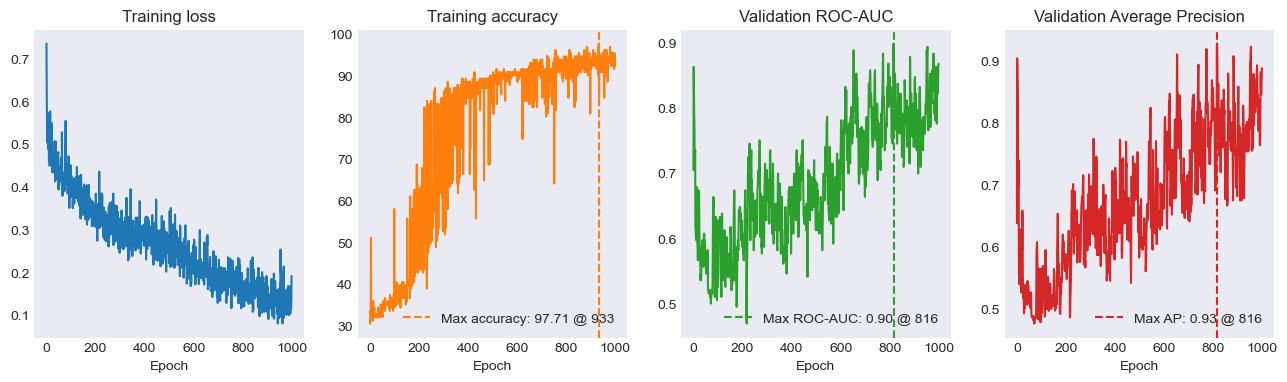

In [8]:
utils.plot_history(history)

## Validation on unseen data
Now, let's use our held-out data to check how well our model handles unseen data.

Test ROC-AUC: 0.8667
Test AP: 0.9531


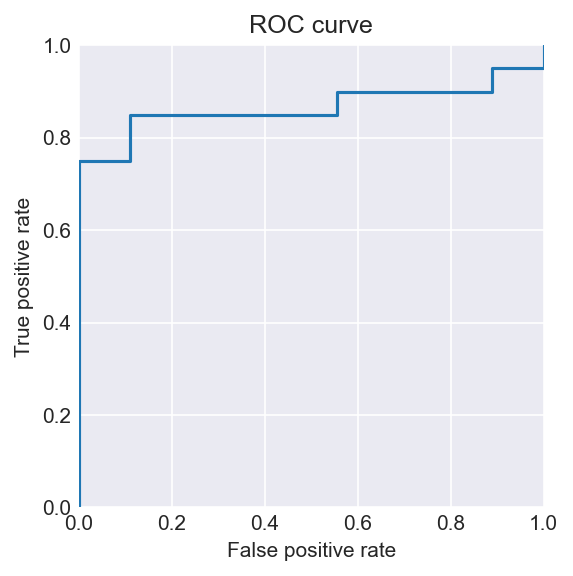

Number of correct positive predictions on test set: 17 out of 20
Number of correct negative predictions on test set: 8 out of 9


In [9]:
test_roc, test_ap, preds, ys = t.test(
    dataloaders[2].dataset, model, return_preds=True
)
print(f"Test ROC-AUC: {test_roc:.4f}")
print(f"Test AP: {test_ap:.4f}")

# Plot the ROC curve
fig = t.plot_roc_curve(dataloaders[2].dataset, model)
print(
    f"Number of correct positive predictions on test set: {torch.sum((preds > 0.5) & (ys == 1)).numpy()} out of {torch.sum(ys == 1).numpy()}"
)
print(
    f"Number of correct negative predictions on test set: {torch.sum((preds < 0.5) & (ys == 0)).numpy()} out of {torch.sum(ys == 0).numpy()}"
)

We can also look at the distribution of predictions, to get a sense of our model's uncertainty :

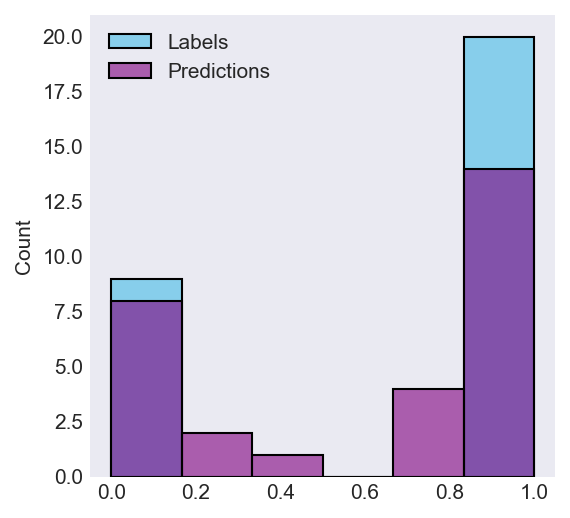

This plot shows the distribution of the labels and predictions; predictions are overlayed on top of the labels, showing whether they are missing or surnumerous.
The labels are 20 positive and 9 negative.
The predictions are 18 positive and 11 negative.


In [10]:
utils.show_preds_distribution(preds, ys)

In [ ]:
utils.plot_confusion_matrix(preds, ys)

In [ ]:
mislabeled = utils.find_mislabeled_molecules(preds, ys.astype(int))
print(f"{len(mislabeled)} mislabeled molecules")
mols = []
for id_mol in mislabeled:
    mols.append(full_dataset[id_mol])

thresh_preds = np.where(preds > 0.5, 1, 0)[mislabeled]
utils.draw_molecule_from_dict(
    mols[:20],
    preds=thresh_preds,
    mol_ids=mislabeled,
    n_cols=4,
    n_rows=5,
    figsize=(8, 10),
)

## Full dataset performance

Out of curiosity, let's see how the model performs on the whole dataset.

We will as before plot the ROC curve and the distribution of predictions;
additionally, we will show which molecules the model misclassified.

In [11]:
data_all = t.create_dataset_dict(add_edge_features=True)
full_dataset = t.MutagDataset(data_all)

### Full ROC curve

Full ROC-AUC: 0.9545
Full AP: 0.9784


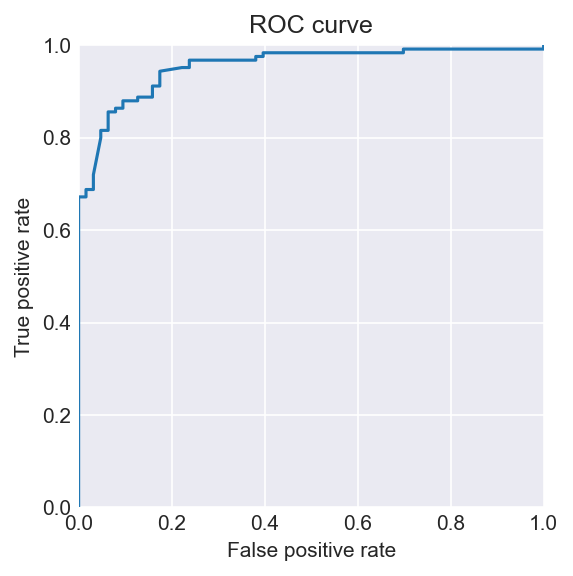

Number of correct positive predictions on test set: 119 out of 125
Number of correct negative predictions on test set: 48 out of 63


In [12]:
full_roc, full_ap, preds, ys = t.test(dataset, model, return_preds=True)
print(f"Full ROC-AUC: {full_roc:.4f}")
print(f"Full AP: {full_ap:.4f}")

# Plot the ROC curve
fig = t.plot_roc_curve(dataset, model)

preds = preds.cpu().detach().numpy()
ys = ys.cpu().detach().numpy()
print(
    f"Number of correct positive predictions on test set: {np.sum((preds > 0.5) & (ys == 1))} out of {np.sum(ys == 1)}"
)
print(
    f"Number of correct negative predictions on test set: {np.sum((preds < 0.5) & (ys == 0))} out of {np.sum(ys == 0)}"
)

### Predictions distribution

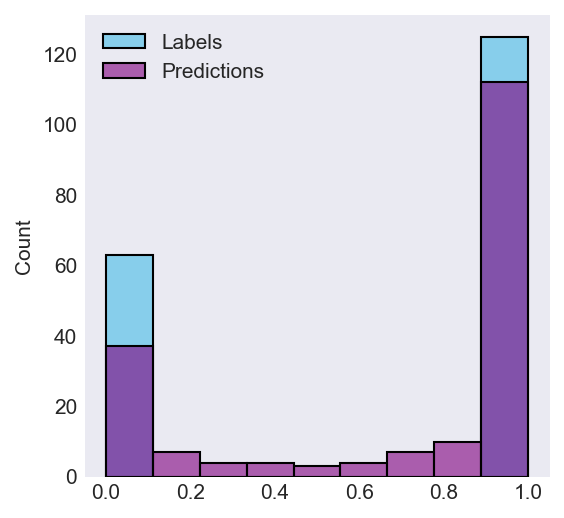

This plot shows the distribution of the labels and predictions; predictions are overlayed on top of the labels, showing whether they are missing or surnumerous.
The labels are 125 positive and 63 negative.
The predictions are 134 positive and 54 negative.


In [13]:
utils.show_preds_distribution(preds, ys)

### Confusion matrix

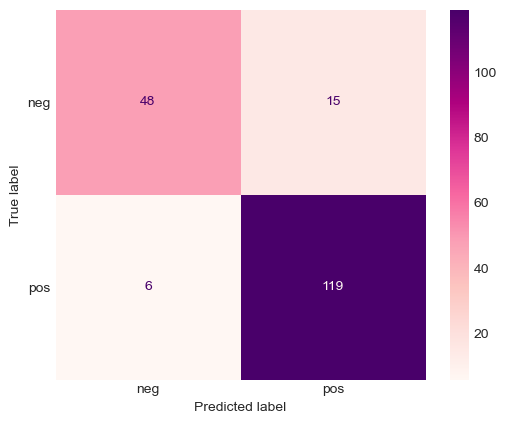

In [14]:
utils.plot_confusion_matrix(preds, ys)

### Check mislabelled molecules

21 mislabeled molecules


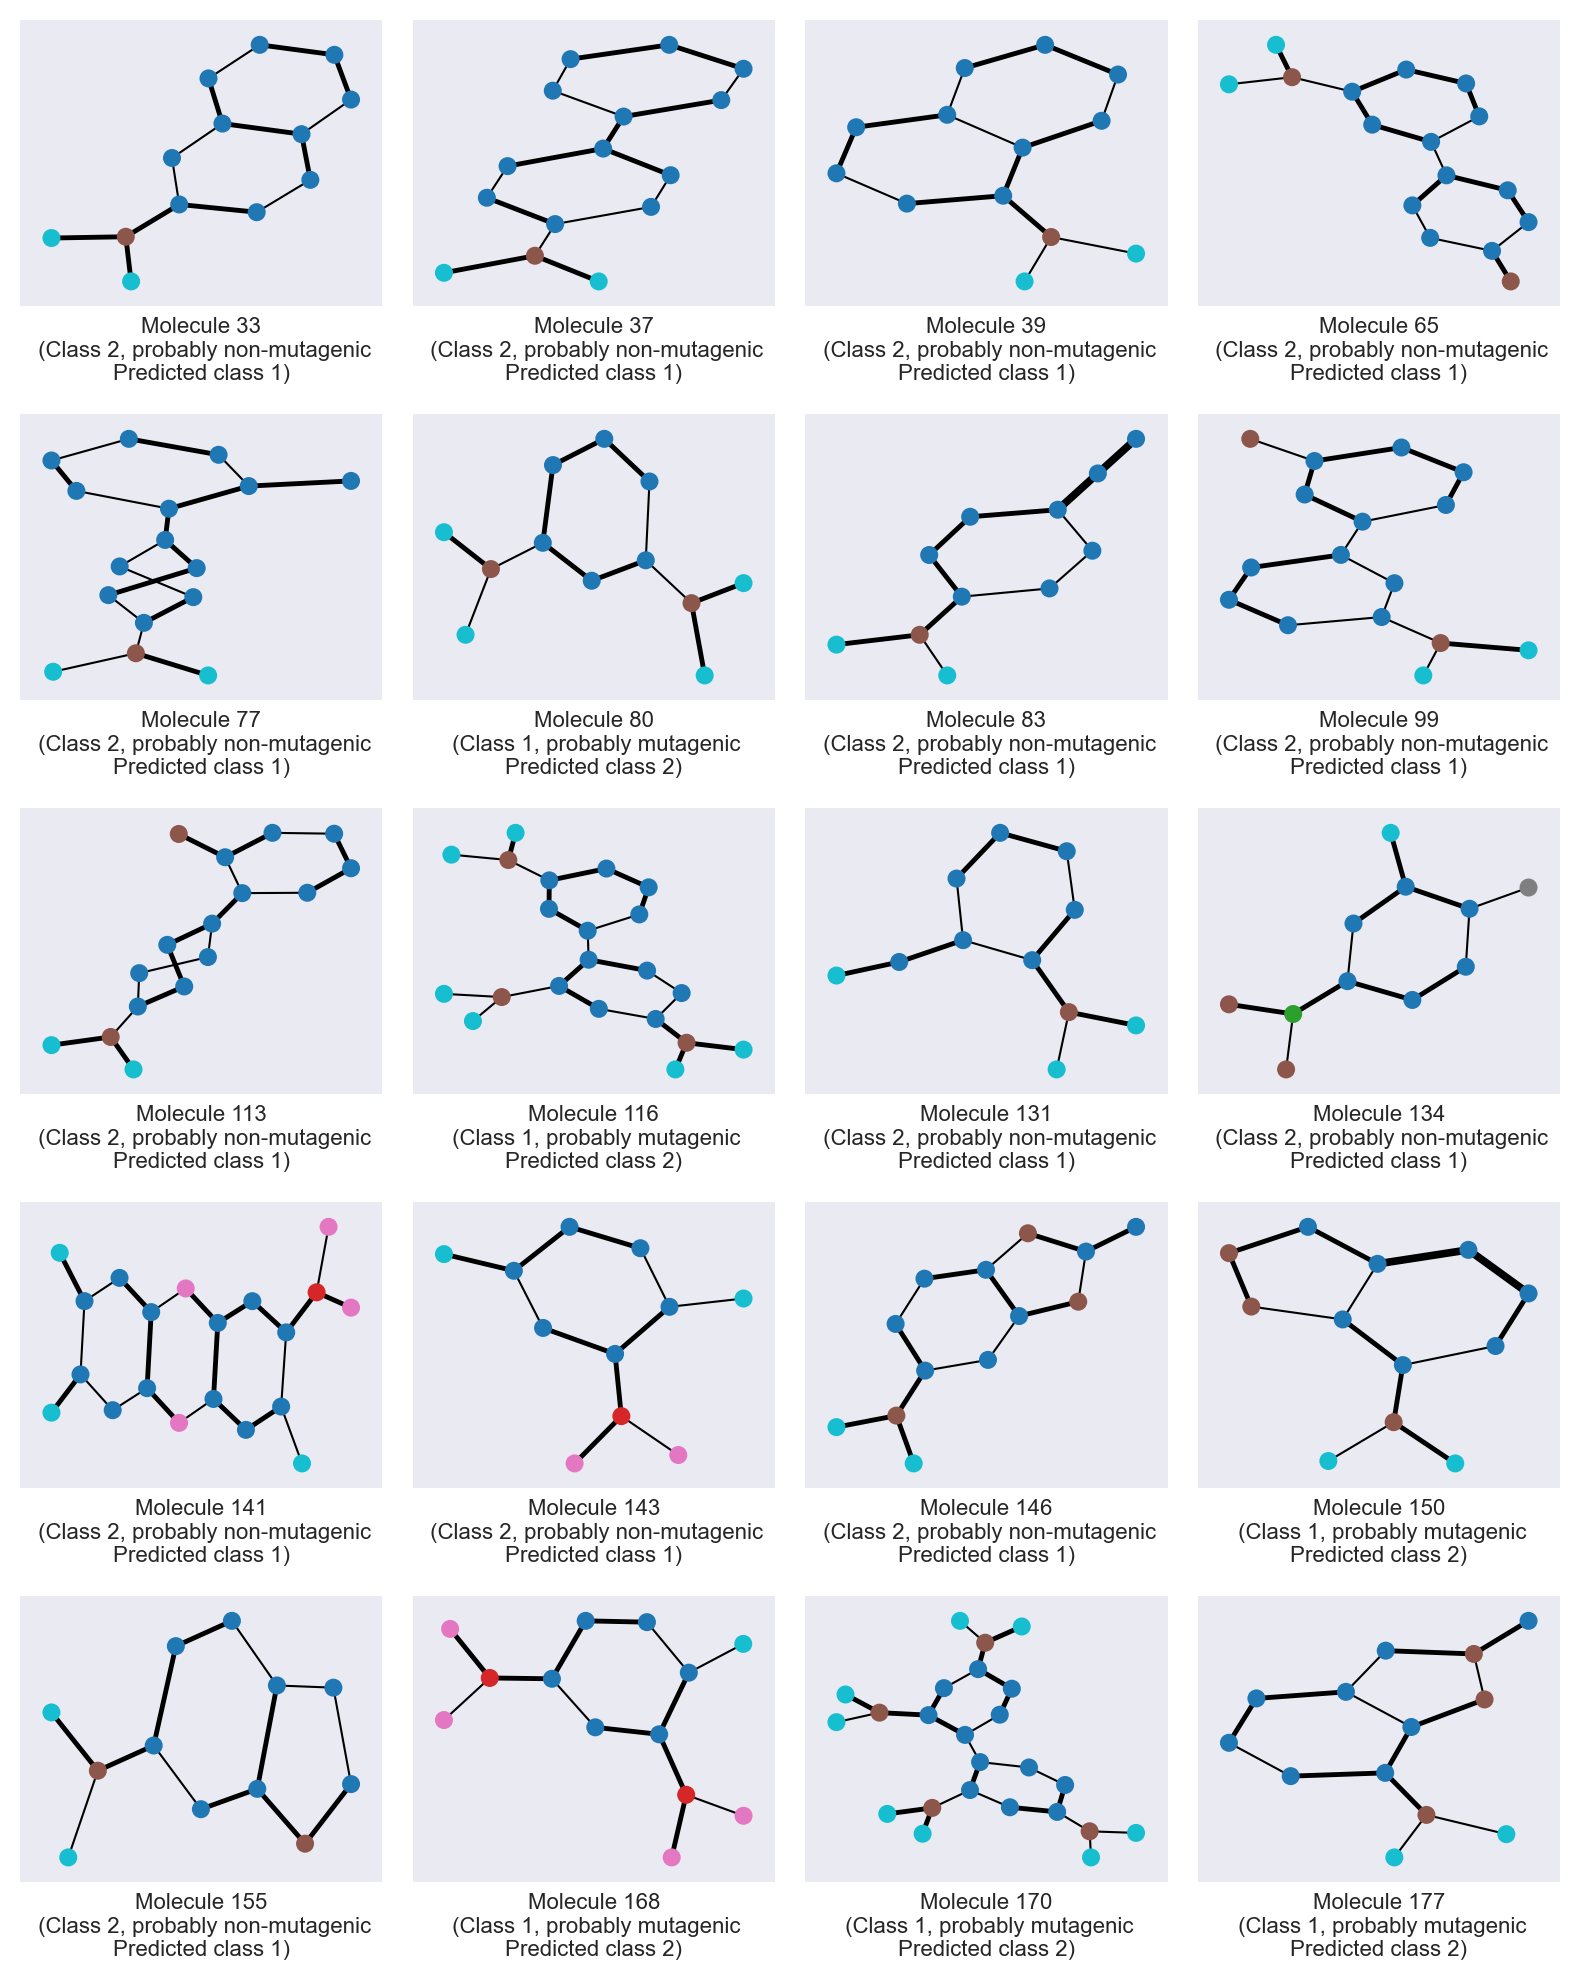

In [15]:
mislabeled = utils.find_mislabeled_molecules(preds, ys.astype(int))
print(f"{len(mislabeled)} mislabeled molecules")
mols = []
for id_mol in mislabeled:
    mols.append(full_dataset[id_mol])

thresh_preds = np.where(preds > 0.5, 1, 0)[mislabeled]
utils.draw_molecule_from_dict(
    mols[:20],
    preds=thresh_preds,
    mol_ids=mislabeled,
    n_cols=4,
    n_rows=5,
    figsize=(8, 10),
)